## Imports

In [1]:
import os
import gym
import math
import datetime
import json

from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env 

import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt


from lib.train import train_standard
from lib.plots import dynamics_cmap, set_plot_env, plot_model, plot_variance
from lib.pandemic_model_tests import SEIVHRD_Env  
from lib.data_structures import build_model_data, build_variance_struct, update_variance_struct

### Some routines used to preprocess the data

In [31]:
"""
Esthetics (The below functions need to be called only once during a session. You should however call 
them whenever you restart your session/kernel)
"""
sns.set_style("whitegrid", {'axes.linewidth': 2, 'font_scale': 1.5, 'axes.edgecolor': '.15'})
set_plot_env()

# Routines to calculate the number of days between two dates. Useful for data preprocessing
def convert_str_date_to_ints(date1, date2):
    # Date is formatted as "yyyy-mm-dd"
    [y1, m1, d1] = [int(elem) for elem in date1.split('-')]
    [y2, m2, d2] = [int(elem) for elem in date2.split('-')]
    if y1 > y2:
        return  (y2, m2, d2), (y1, m1, d1)
    elif y1 < y2:
        return  (y1, m1, d1), (y2, m2, d2)
    
    if m1 > m2:
        return  (y2, m2, d2), (y1, m1, d1)
    elif m1 < m2:
        return  (y1, m1, d1), (y2, m2, d2)
    
    if d1 > d2:
        return  (y2, m2, d2), (y1, m1, d1)
    
    return  (y1, m1, d1), (y2, m2, d2)
    
    
def is_leap(year):
    if (year % 4 == 0):
        if (year % 100 != 0):
            return True
        else:
            return (year % 400 == 0)
    return False


def get_number_of_days(y, m):
    if m in {1,3,5,7,8,10,12}:
        return 31
    elif m in {4,6,9,11}:
        return 30
    else:
        return 29 if  is_leap(y) else 28

def daysBetweenDates(y1, m1, d1, y2, m2, d2) -> int:
    # Assumes y2 >= y1
    days = 0
    # Years
    for y in range(y1 + 1, y2):
        for m in range(1, 13):
            days += get_number_of_days(y, m)
    # Months
    if y1 < y2:
        for m in range(m1 + 1, 13):
            days += get_number_of_days(y1, m)

        for m in range(1, m2):
            days += get_number_of_days(y2, m)

    else:
        for m in range(m1 + 1, m2):
            days += get_number_of_days(y1, m)


    # Days
    if y1 == y2 and m1 == m2:
        days += d2 - d1
    else:
        days += get_number_of_days(y1, m1) - d1  + d2

    return days

# This function returns chunks of continuous times in which there are no NaNs... In the event there is a NaN in the middle, the chunks are split in two halfs
# fragmented.
def get_chunks(df, location_key, locations, features, output_dic = "./dic.pkl"):
    global_dic = {}
    
    # Load the dataframe
    #df = pd.read_csv(df_path)
    
    # Process countries
    for location in locations:
        loc_df = df[df[location_key].isin([location])]
        global_dic[location] = {}
        
        # Process features
        for feat in features:
            #feat_df = loc_df.loc[loc_df.columns[loc_df.columns.isin([feat, location_key, 'date'])]]
            feat_df = loc_df[loc_df.columns[loc_df.columns.isin([feat, location_key, 'date'])]]

            prev_date, global_dic[location][feat] = None, []
            curr_chunk, curr_date = [], None
            
            if len(feat_df.columns) != 3:
                continue
            
            feat_df = feat_df.dropna()
            if len(feat_df) == 0:
                continue            

            for index, row in feat_df.iterrows():
                curr_date = row['date']
                if prev_date is None:
                    prev_date = curr_date
                    curr_chunk.append(prev_date)
                    continue
                date1, date2 = convert_str_date_to_ints(prev_date, curr_date)
                diff = daysBetweenDates(*date1, *date2)
                if diff > 1:
                    curr_chunk.append(prev_date)
                    global_dic[location][feat].append(curr_chunk)
                    curr_chunk = [curr_date]
                prev_date = curr_date
            if curr_date is not None:   
                curr_chunk.append(curr_date)
                if len(curr_chunk) == 1:
                    curr_chunk.append(curr_date)
                global_dic[location][feat].append(curr_chunk)
    global_dic = compute_effective_range(global_dic)
    with open(output_dic, "wb") as fp:
        pkl.dump(global_dic, fp)
    return global_dic

def cut_down_dates(df, global_dic):
    for country_name, value in global_dic.items():
        start_date, end_date = value['effective_range'][0], value['effective_range'][1]
        # Truncate to the effective range
        index = df.loc[(df['location'] == country_name) & ((df['date'] < start_date) | (df['date'] > end_date))].index
        df = df.drop(index , inplace=False)
    return df



def filter_sets(reference, dropouts):
    new_set = set()
    for elem in reference:
        if elem not in dropouts:
            new_set.add(elem)
    return new_set
    

    
def compute_effective_range(dic):
    for country, entries in dic.items():
        min_date, max_date = '0000-01-01', '3000-12-31' 
        for v_list in entries.values():
            if not v_list:
                continue
            start, end = v_list[0][0], v_list[-1][-1]
            if start > min_date:
                min_date = start
            if end < max_date:
                max_date = end
        if min_date != '0000-01-01':
            dic[country]['effective_range'] = [min_date, max_date]
    return dic


In [26]:
dic_missing_inter

{'Japan': {'new_persons_vaccinated': [['2021-02-18', '2021-02-19'],
   ['2021-02-22', '2021-02-22'],
   ['2021-02-24', '2021-02-26'],
   ['2021-03-01', '2021-03-05'],
   ['2021-03-08', '2021-03-12'],
   ['2021-03-15', '2021-03-19'],
   ['2021-03-22', '2021-03-26'],
   ['2021-03-29', '2021-04-02'],
   ['2021-04-05', '2021-04-09'],
   ['2021-04-12', '2022-09-14']],
  'new_recovered': [],
  'new_persons_fully_vaccinated': [['2021-03-11', '2021-03-12'],
   ['2021-03-15', '2021-03-19'],
   ['2021-03-22', '2021-03-26'],
   ['2021-03-29', '2021-04-02'],
   ['2021-04-05', '2021-04-09'],
   ['2021-04-12', '2022-09-14']],
  'new_deceased': [['2021-02-17', '2021-02-19'],
   ['2021-02-22', '2021-02-22'],
   ['2021-02-24', '2021-02-26'],
   ['2021-03-01', '2021-03-05'],
   ['2021-03-08', '2021-03-12'],
   ['2021-03-15', '2021-03-19'],
   ['2021-03-22', '2021-03-26'],
   ['2021-03-29', '2021-04-02'],
   ['2021-04-05', '2021-04-09'],
   ['2021-04-12', '2022-09-14']],
  'new_confirmed': [['2021-02-17'

In [3]:
data_dir, data_file = "./data/owid/", "owid-covid-data.csv"
world_data = pd.read_csv(os.path.join(data_dir, data_file))
world_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [4]:
data_dir, data_file = "./data/owid", "owid-covid-data.csv"
world_data = pd.read_csv(os.path.join(data_dir, data_file))

# Define the columns we are going to use
features = [
    "location",                  # Country
    "date",                      # Date
    "population",                # Size of population
    "new_cases_smoothed",        # Useful to calculate the infected I compartment 
    "new_deaths_smoothed",       # Useful to calculate the dead D compartment
    "new_vaccinations_smoothed", # Useful to calculate the vaccinated V compartment (smoothed)
    "hospital_beds_per_thousand",# The number of hospital beds
    "hosp_patients",             # The hospitalized compartment H
]


# Define the countries we are going to check
countries = [
    "Italy",
    "France", 
    "United States", 
    "United Kingdom", 
    "South Africa", 
    "Japan", 
    "Sweden",
    "Canada",
    "Malaysia",
    "South Korea",
]

# get the country dataframe
world_data = world_data[world_data["location"].isin(countries)]
world_data = world_data[features]
# Choose the start/end dates
#start_date,end_date = "2021-05-01","2022-05-01"

# Only keep 1 year interval
#world_data = world_data[(world_data['date'] > start_date) & (world_data['date'] <= end_date)]

# Population numbers
#for country in countries:
#    print(f"[{country}] == {np.unique(world_data[world_data['location'] == country]['population']).item()}")

# Process first dataframe
get_chunks(world_data, "location", countries, features, output_dic = "./data/owid/preprocessed/owid-dic.pkl")
dic = {}
with open("./data/owid/preprocessed/all_countries_chunks.pkl", "rb") as fp:
    dic = pkl.load(fp)
world_data = cut_down_dates(world_data, dic)
world_data = world_data.interpolate(method='linear')
#world_data['cum_new_cases_smoothed'] = world_data['new_cases_smoothed'].cumsum()
#world_data['D'] = world_data['new_deaths_smoothed'].cumsum()
world_data['H'] = world_data['hosp_patients']

In [5]:
world_data.to_csv("./data/owid/final_owid_df.csv")

In [6]:
world_data = pd.read_csv("./data/owid/preprocessed/final_owid_df.csv")
for country in countries:
    c_data = world_data[world_data.location.isin([country])]
    print(f"country == {country}, population = {np.unique(c_data['population']).item()}")

country == Italy, population = 59037472.0
country == France, population = 67813000.0
country == United States, population = 338289856.0
country == United Kingdom, population = 67508936.0
country == South Africa, population = 59893884.0
country == Japan, population = 123951696.0
country == Sweden, population = 10549349.0
country == Canada, population = 38454328.0
country == Malaysia, population = 33938216.0
country == South Korea, population = 51815808.0


What we are trying to do is:
* Try to have all the variables we use in our dynamical system.
* Find one year period where there are no missing values (for each country, not necessary to have the same period of all selected countries).
Due to inconsistency and missingness of data, you can supplement this dataframe with data coming form here: https://github.com/GoogleCloudPlatform/covid-19-open-data

Sample code for plotting

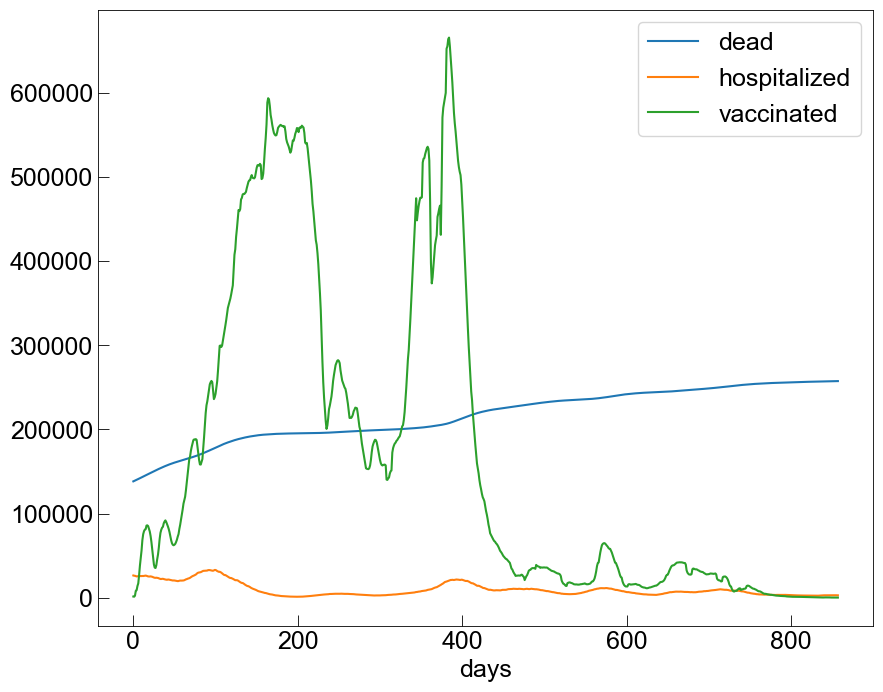

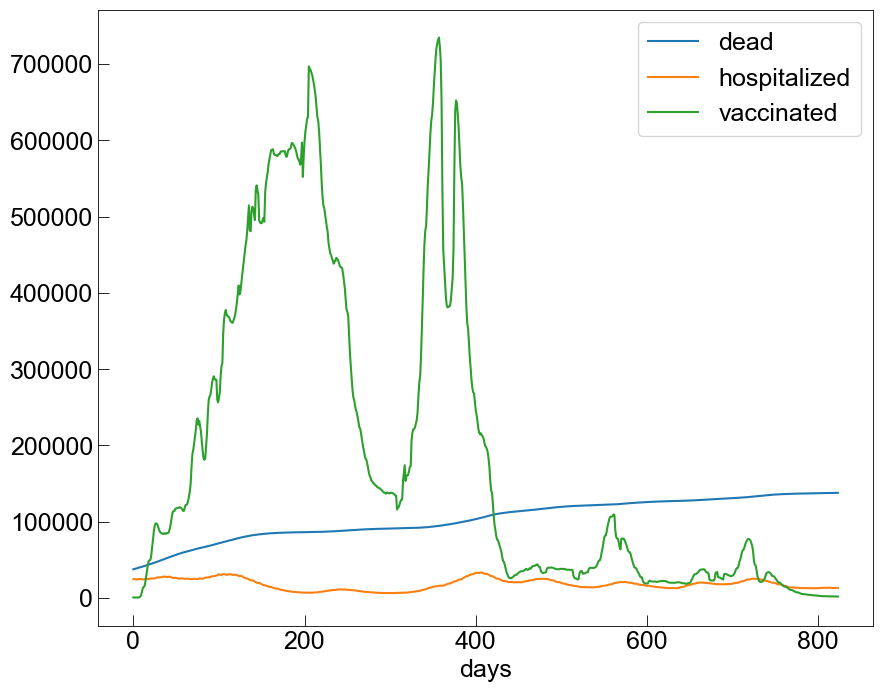

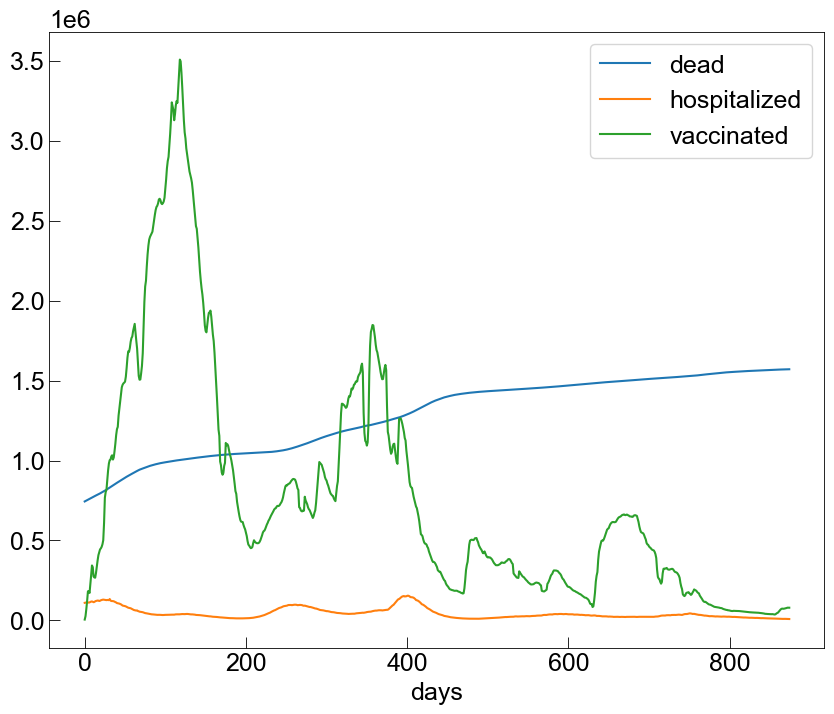

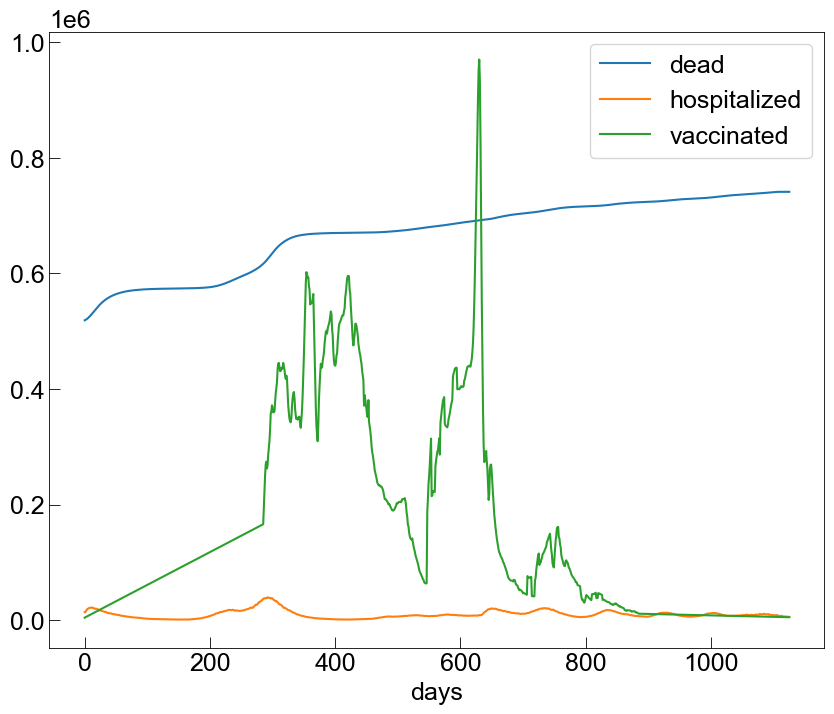

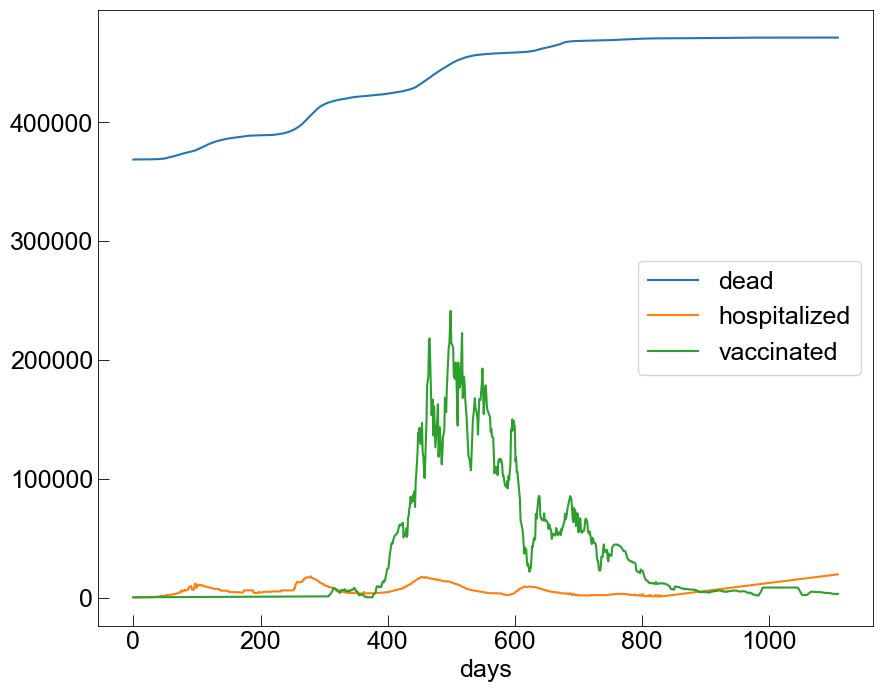

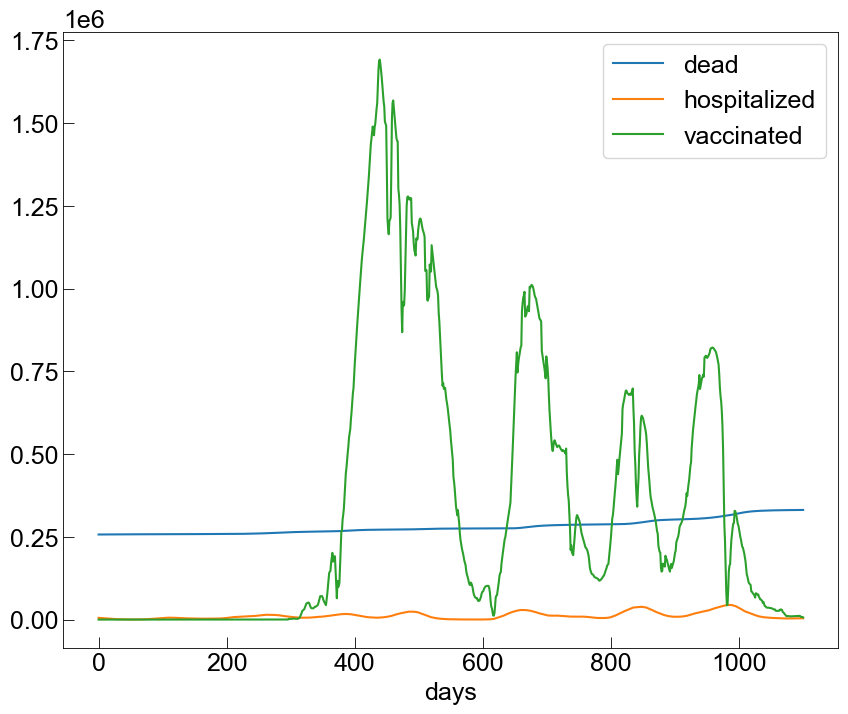

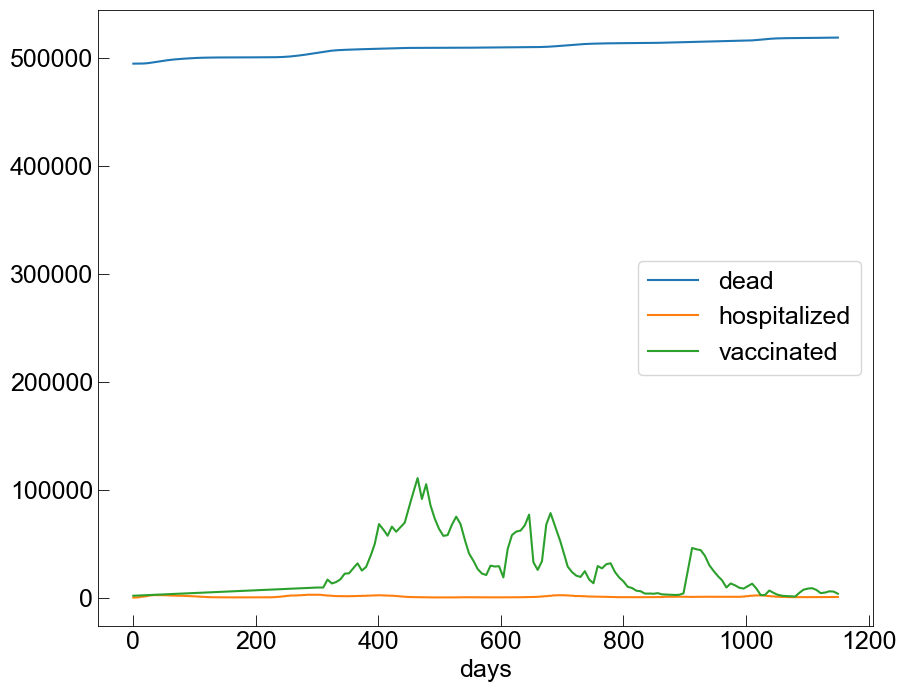

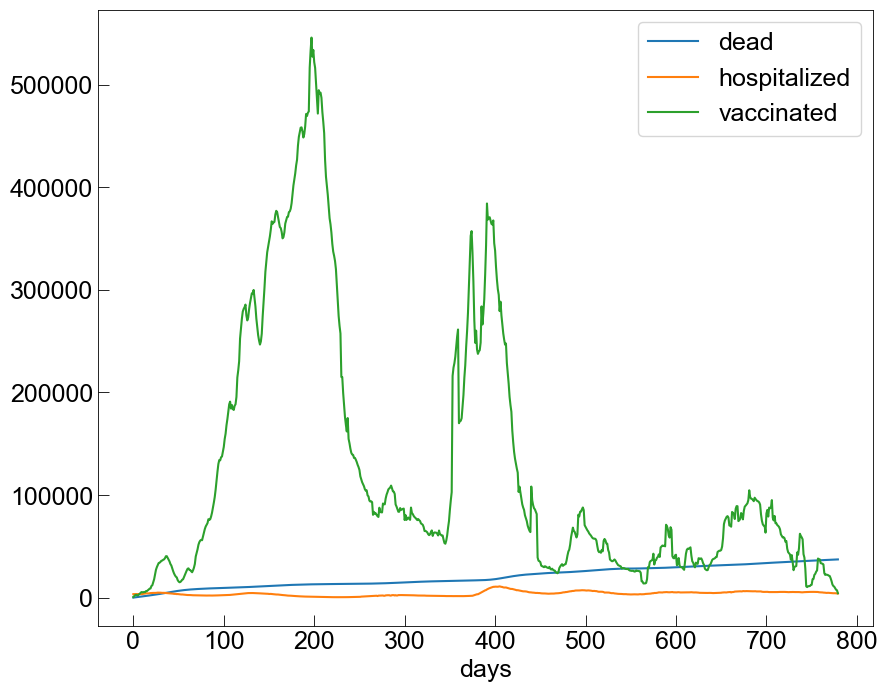

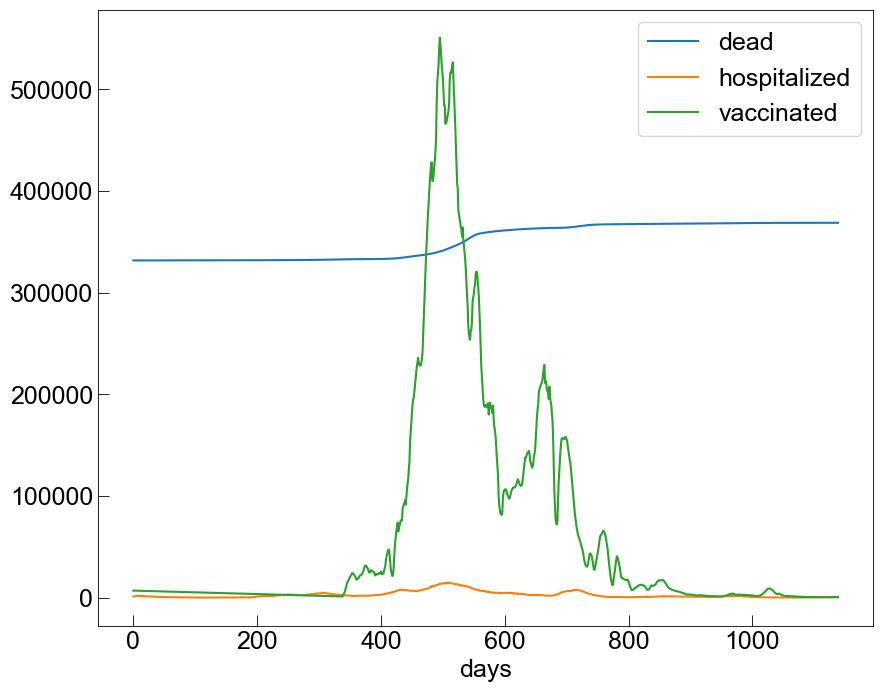

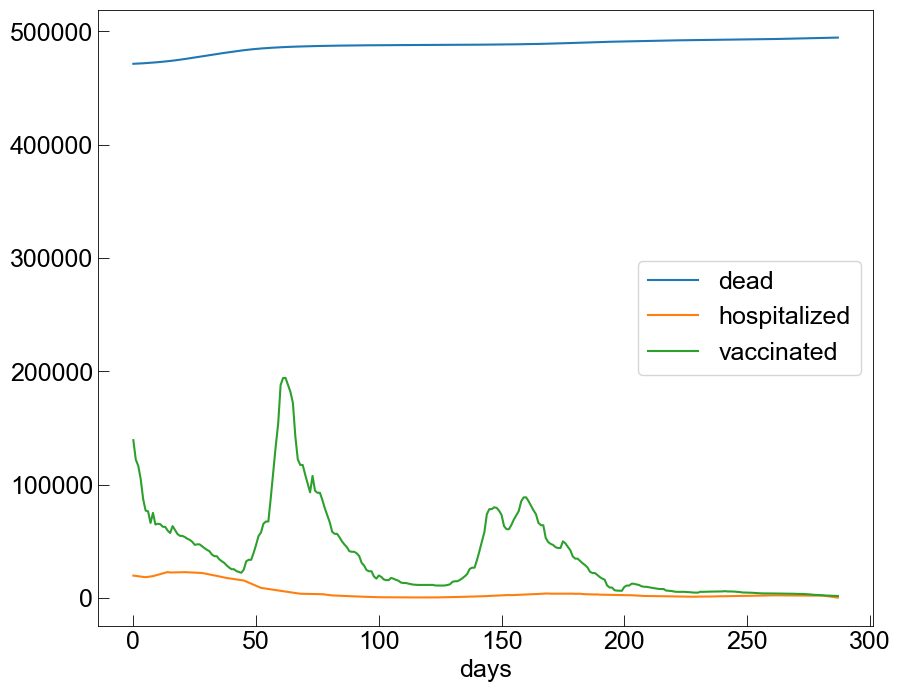

In [9]:

for country in countries:
    country_data = world_data[world_data["location"]==country]
    days = np.arange(country_data.shape[0])
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    # the infected I compartment
    #plt.plot(days, country_data["new_cases"].values)
    # the dead D compartment
    plt.plot(days, country_data["D"].values)
    # the hospitalized H compartment
    plt.plot(days, country_data["H"].values)
    # the vaccinated V compartment
    plt.plot(days, country_data["new_vaccinations_smoothed"].values)
    #plt.grid(False)
    #plt.legend(['infected', 'dead', 'hospitalized', 'vaccinated'])
    plt.legend(['dead', 'hospitalized', 'vaccinated'])
    plt.xlabel('days')
    
    """ Code to save plots """ 
    #plt.savefig(f"{country}_data.pdf", pad_inches=0, bbox_inches='tight', transparent=True) 


# GCP data
We hope this data is more complete

In [21]:
# Define the columns we are going to use
features = {
    "location_key",                  # Country
    "date",                          # Date
    "population",                    # Size of population
    "new_confirmed",                 # the infected I compartment
    "new_deceased",                  # the dead D compartment
    "new_recovered",                 # the recovered D compartment
    "current_hospitalized_patients", # the hospitalized H compartment
    "new_intensive_care_patients",   # Possible alternative to the H compartment 
    "new_persons_fully_vaccinated",  # the vaccinated V compartment 
    "new_persons_vaccinated",        # Possible alternative to the V compartment
    "hospital_beds_per_1000",        # The number of hospital beds (per 1000 persons)
}


countries = [
    "Italy",
    "France", 
    "United States", 
    "United Kingdom", 
    "South Africa", 
    "Japan", 
    "Sweden",
    "Canada",
    "Malaysia",
    "South Korea",
]

feat_by_country = {
    "Italy": features,
    "France": features, 
    "United States": features, 
    "United Kingdom": features, 
    "South Africa": features, 
    "Japan": features, 
    "Sweden": features,
    "Canada": features,
    "Malaysia": features,
    "South Korea": features,
}



countries_no_features = {"South Korea","South Africa","Canada"}
countries_all_features = {"Italy", "France", "Malaysia"}

countries_missing_features = {
    "Japan":['new_recovered', 'current_hospitalized_patients'],
    "United Kingdom":['new_recovered'],
    "United States":['new_recovered']
}



# Define the countries we are going to check
loc_name_to_key = {
    "Italy": "IT",
    "France": "FR", 
    "United States of America": "US", 
    "United Kingdom": "GB", 
    "Sweden": "SE",
    "Canada": "CA",
    "South Corea": "KR",
    "Japan":"JP", 
    "Sweden":"SE",
    "Canada":"CA",
    "Malaysia":"MY",
    "South Africa":"ZA"
}

key_2_loc_name = {
    "IT":"Italy",
    "FR":"France", 
    "US":"United States of America", 
    "GB":"United Kingdom", 
    "SE":"Sweden",
    "CA":"Canada",
    "KR":"South Corea",
    "JP":"Japan", 
    "SE":"Sweden",
    "CA":"Canada",
    "MY":"Malaysia",
    "ZA":"South Africa"
}

# Define the countries keys
location_keys = {"IT","FR","US","GB","SE","CA","KR","ZA","JP","MY"}

In [22]:
"""
# Index
data_dir, data_file = "./data/gcp", "index.csv"
idx_data = pd.read_csv(os.path.join(data_dir, data_file))
idx_data = idx_data[idx_data.columns[idx_data.columns.isin(['country_name', 'country_code'])]]
idx_data = idx_data.rename(columns={"country_name": "location"})
idx_data.replace('United States of America', 'United States', inplace=True)
idx_data = idx_data[idx_data.location.isin(countries)]
"""
#idx_data = idx_data.reindex(columns=['location_key', 'population'])

# Hospitals data
data_dir, data_file = "./data/gcp", "hospitalizations.csv"
hos_data = pd.read_csv(os.path.join(data_dir, data_file))
hos_data = hos_data[hos_data["location_key"].isin(location_keys)]
hos_data = hos_data[hos_data.columns[hos_data.columns.isin(['date', 'location_key', 'current_hospitalized_patients', 'hospital_beds_per_1000'])]]
hos_data['location'] = hos_data.apply(lambda row: key_2_loc_name[row.location_key], axis = 1)
hos_data.replace('United States of America', 'United States', inplace=True)
hos_data = hos_data[hos_data.location.isin(countries)]
hos_data = hos_data.drop(columns=['location_key'])
#hos_data = hos_data.reindex(columns=['date', 'location_key', 'new_hospitalized_patients','new_intensive_care_patients'])

# Epidemiological data
data_dir, data_file = "./data/gcp", "epidemiology.csv"
epi_data = pd.read_csv(os.path.join(data_dir, data_file))
epi_data = epi_data[epi_data["location_key"].isin(location_keys)]
epi_data = epi_data[epi_data.columns[epi_data.columns.isin(['date', 'location_key', 'new_confirmed', 'new_deceased', 'new_recovered'])]]
epi_data['location'] = epi_data.apply(lambda row: key_2_loc_name[row.location_key], axis = 1)
epi_data.replace('United States of America', 'United States', inplace=True)
epi_data = epi_data[epi_data.location.isin(countries)]
epi_data = epi_data.drop(columns=['location_key'])
epi_data
#epi_data = epi_data.reindex(columns=['date', 'location_key', 'new_confirmed', 'cumulative_deceased', 'new_recovered'])

# Vaccination data
data_dir, data_file = "./data/gcp", "vaccinations.csv"
vac_data = pd.read_csv(os.path.join(data_dir, data_file))
vac_data = vac_data[vac_data["location_key"].isin(location_keys)]
vac_data = vac_data[vac_data.columns[vac_data.columns.isin(['date', 'location_key', 'new_persons_vaccinated', 'new_persons_fully_vaccinated'])]]
vac_data['location'] = vac_data.apply(lambda row: key_2_loc_name[row.location_key], axis = 1)
vac_data.replace('United States of America', 'United States', inplace=True)
vac_data = vac_data[vac_data.location.isin(countries)]
vac_data = vac_data.drop(columns=['location_key'])
#vac_data = epi_data.reindex(columns=['date', 'location_key', 'new_persons_vaccinated', 'new_persons_fully_vaccinated'])


# Health data
data_dir, data_file = "./data/gcp", "health.csv"
hea_data = pd.read_csv(os.path.join(data_dir, data_file))
hea_data = hea_data[hea_data["location_key"].isin(location_keys)]
hea_data = hea_data[hea_data.columns[hea_data.columns.isin(['location_key', 'hospital_beds_per_1000'])]]
hea_data['location'] = hea_data.apply(lambda row: key_2_loc_name[row.location_key], axis = 1)
hea_data.replace('United States of America', 'United States', inplace=True)
hea_data = hea_data[hea_data.location.isin(countries)]
hea_data = hea_data.drop(columns=['location_key'])
#hea_data = epi_data.reindex(columns=['location_key', 'hospital_beds_per_1000'])

# Demographics data
data_dir, data_file = "./data/gcp", "demographics.csv"
dem_data = pd.read_csv(os.path.join(data_dir, data_file))
dem_data = dem_data[dem_data["location_key"].isin(location_keys)]
dem_data = dem_data[dem_data.columns[dem_data.columns.isin(['location_key', 'population'])]]
dem_data['location'] = dem_data.apply(lambda row: key_2_loc_name[row.location_key], axis = 1)
dem_data.replace('United States of America', 'United States', inplace=True)
dem_data = dem_data[dem_data.location.isin(countries)]
dem_data = dem_data.drop(columns=['location_key'])
#dem_data = epi_data.reindex(columns=['location_key', 'population'])

df_final = pd.merge(hos_data, epi_data, on=['date', 'location'])
df_final = pd.merge(df_final, vac_data, on=['date', 'location'])
#df_final = pd.merge(df_final, hea_data, on=['location_key'])
#df_final = pd.merge(df_final, dem_data, on=['location_key'])
df_final


,date,current_hospitalized_patients,location,new_confirmed,new_deceased,new_recovered,new_persons_vaccinated,new_persons_fully_vaccinated
0,2020-12-27,24620.0,France,8822.0,173.0,189941.0,609.0,55.0
1,2020-12-28,24645.0,France,2960.0,363.0,190722.0,683.0,42.0
2,2020-12-29,24743.0,France,11395.0,384.0,191806.0,384.0,19.0
3,2020-12-30,24560.0,France,26457.0,303.0,193045.0,443.0,18.0
4,2020-12-31,24407.0,France,19927.0,251.0,194221.0,440.0,23.0
...,...,...,...,...,...,...,...,...
3711,2022-09-10,27947.0,United States,19715.0,51.0,NaN,26248.0,0.0
3712,2022-09-11,28016.0,United States,16742.0,10.0,NaN,15585.0,0.0
3713,2022-09-12,28277.0,United States,60728.0,213.0,NaN,23997.0,0.0
3714,2022-09-13,27766.0,United States,54413.0,460.0,NaN,3637.0,0.0


In [32]:
features_to_process = {
    "new_confirmed",                 # the infected I compartment
    "new_deceased",                  # the dead D compartment
    "new_recovered",                 # the recovered D compartment
    "current_hospitalized_patients", # the hospitalized H compartment
    "new_persons_fully_vaccinated",  # the vaccinated V compartment 
    "new_persons_vaccinated",        # Possible alternative to the V compartment
}
dic_missing_inter = get_chunks(df_final, "location", countries_missing_features.keys(), features_to_process, output_dic = "./data/gcp/preprocessed/missing_countries_chunks_gcp_inter.pkl")
dic_all_inter = get_chunks(df_final, "location", countries_all_features, features_to_process, output_dic = "./data/gcp/preprocessed/all_countries_chunks_gcp_inter.pkl")

In [34]:
dic_all_inter

{'Malaysia': {'new_persons_vaccinated': [['2021-02-24', '2022-09-15']],
  'new_recovered': [['2021-02-24', '2022-09-15']],
  'new_persons_fully_vaccinated': [['2021-02-24', '2022-09-15']],
  'new_deceased': [['2021-02-24', '2022-09-15']],
  'new_confirmed': [['2021-02-24', '2022-09-15']],
  'current_hospitalized_patients': [['2021-02-24', '2022-09-15']],
  'effective_range': ['2021-02-24', '2022-09-15']},
 'Italy': {'new_persons_vaccinated': [['2020-12-27', '2022-09-14']],
  'new_recovered': [['2020-12-27', '2022-09-14']],
  'new_persons_fully_vaccinated': [['2020-12-27', '2022-09-14']],
  'new_deceased': [['2020-12-27', '2022-09-14']],
  'new_confirmed': [['2020-12-27', '2022-09-14']],
  'current_hospitalized_patients': [['2020-12-27', '2022-09-14']],
  'effective_range': ['2020-12-27', '2022-09-14']},
 'France': {'new_persons_vaccinated': [['2020-12-27', '2022-09-14']],
  'new_recovered': [['2020-12-27', '2022-05-17']],
  'new_persons_fully_vaccinated': [['2020-12-27', '2022-09-14']]

In [20]:
countries_missing_features = {
    "Japan":['new_recovered', 'current_hospitalized_patients'],
    "United Kingdom":['new_recovered'],
    "United States":['new_recovered']
}


for country, vals in countries_missing_features.items():
    print(f"Checking {country}: missing values should be {vals}")
    res = []
    for k, v in  dic_missing_inter[country].items():
        if len(v) == 0:
            res.append(k)
    print(f"Actual values are: {res}")

Checking Japan: missing values should be ['new_recovered', 'current_hospitalized_patients']
Actual values are: ['new_recovered', 'current_hospitalized_patients']
Checking United Kingdom: missing values should be ['new_recovered']
Actual values are: ['new_recovered']
Checking United States: missing values should be ['new_recovered']
Actual values are: ['new_recovered']


In [9]:
# As a reminder columns we are going to use
static_features = {
    "location",                    # Country
    "population",                  # Size of population
}

features = {'date', 
            'location', 
            'new_confirmed', 
            'new_recovered',
            'new_deceased', 
            'new_persons_vaccinated', 
            'new_persons_fully_vaccinated',
            'current_hospitalized_patients'}

dic_all = {}
with open("./data/gcp/preprocessed/all_countries_chunks_gcp.pkl", "rb") as fp:
    dic_all = pkl.load(fp)
#dic_all['France']['effective_range'][-1] = '2022-05-17'
dic_all

{'Italy': {'date': [['2020-12-27', '2022-09-14']],
  'location': [['2020-12-27', '2022-09-14']],
  'new_confirmed': [['2020-12-27', '2022-09-14']],
  'new_recovered': [['2020-12-27', '2022-09-14']],
  'cumulative_deceased': [['2020-12-27', '2022-09-14']],
  'new_persons_vaccinated': [['2020-12-27', '2022-09-14']],
  'new_persons_fully_vaccinated': [['2020-12-27', '2022-09-14']],
  'current_hospitalized_patients': [['2020-12-27', '2022-09-14']],
  'effective_range': ['2020-12-27', '2022-09-14']},
 'France': {'date': [['2020-12-27', '2022-09-14']],
  'location': [['2020-12-27', '2022-09-14']],
  'new_confirmed': [['2020-12-27', '2022-09-14']],
  'new_recovered': [['2020-12-27', '2022-05-17']],
  'cumulative_deceased': [['2020-12-27', '2022-09-14']],
  'new_persons_vaccinated': [['2020-12-27', '2022-09-14']],
  'new_persons_fully_vaccinated': [['2020-12-27', '2022-09-14']],
  'current_hospitalized_patients': [['2020-12-27', '2022-09-14']],
  'effective_range': ['2020-12-27', '2022-05-17']

In [36]:
with open("./data/gcp/preprocessed/all_countries_chunks_gcp_inter.pkl", "rb") as fp:
    dic_all = pkl.load(fp)
dic_all

{'Malaysia': {'new_persons_vaccinated': [['2021-02-24', '2022-09-15']],
  'new_recovered': [['2021-02-24', '2022-09-15']],
  'new_persons_fully_vaccinated': [['2021-02-24', '2022-09-15']],
  'new_deceased': [['2021-02-24', '2022-09-15']],
  'new_confirmed': [['2021-02-24', '2022-09-15']],
  'current_hospitalized_patients': [['2021-02-24', '2022-09-15']],
  'effective_range': ['2021-02-24', '2022-09-15']},
 'Italy': {'new_persons_vaccinated': [['2020-12-27', '2022-09-14']],
  'new_recovered': [['2020-12-27', '2022-09-14']],
  'new_persons_fully_vaccinated': [['2020-12-27', '2022-09-14']],
  'new_deceased': [['2020-12-27', '2022-09-14']],
  'new_confirmed': [['2020-12-27', '2022-09-14']],
  'current_hospitalized_patients': [['2020-12-27', '2022-09-14']],
  'effective_range': ['2020-12-27', '2022-09-14']},
 'France': {'new_persons_vaccinated': [['2020-12-27', '2022-09-14']],
  'new_recovered': [['2020-12-27', '2022-05-17']],
  'new_persons_fully_vaccinated': [['2020-12-27', '2022-09-14']]

In [37]:
dic_missing = None
with open("./data/gcp/preprocessed/missing_countries_chunks_gcp_inter.pkl", "rb") as fp:
    dic_missing = pkl.load(fp)
dic_missing

{'Japan': {'new_persons_vaccinated': [['2021-02-18', '2021-02-19'],
   ['2021-02-22', '2021-02-22'],
   ['2021-02-24', '2021-02-26'],
   ['2021-03-01', '2021-03-05'],
   ['2021-03-08', '2021-03-12'],
   ['2021-03-15', '2021-03-19'],
   ['2021-03-22', '2021-03-26'],
   ['2021-03-29', '2021-04-02'],
   ['2021-04-05', '2021-04-09'],
   ['2021-04-12', '2022-09-14']],
  'new_recovered': [],
  'new_persons_fully_vaccinated': [['2021-03-11', '2021-03-12'],
   ['2021-03-15', '2021-03-19'],
   ['2021-03-22', '2021-03-26'],
   ['2021-03-29', '2021-04-02'],
   ['2021-04-05', '2021-04-09'],
   ['2021-04-12', '2022-09-14']],
  'new_deceased': [['2021-02-17', '2021-02-19'],
   ['2021-02-22', '2021-02-22'],
   ['2021-02-24', '2021-02-26'],
   ['2021-03-01', '2021-03-05'],
   ['2021-03-08', '2021-03-12'],
   ['2021-03-15', '2021-03-19'],
   ['2021-03-22', '2021-03-26'],
   ['2021-03-29', '2021-04-02'],
   ['2021-04-05', '2021-04-09'],
   ['2021-04-12', '2022-09-14']],
  'new_confirmed': [['2021-02-17'

In [43]:
with open("./data/gcp/preprocessed/all_countries_chunks_gcp_inter.pkl", "rb") as fp:
    dic = pkl.load(fp)
df_all = df_final.loc[df_final.location.isin(list(dic.keys()))]
#df_all = cut_down_dates(df_all , dic).interpolate(method='linear')
df_all = cut_down_dates(df_all , dic)
df_all.to_csv("./data/gcp/preprocessed/all_gcp_df.csv")


with open("./data/gcp/preprocessed/missing_countries_chunks_gcp_inter.pkl", "rb") as fp:
    dic = pkl.load(fp)
df_missing = df_final.loc[df_final.location.isin(list(dic.keys()))]
df_missing = df_missing.loc[:, ~df_missing.columns.isin(['new_recovered'])]

df_missing = cut_down_dates(df_missing , dic).interpolate(method='linear')
df_missing.to_csv("./data/gcp/preprocessed/missing_gcp_df.csv")

######################## France


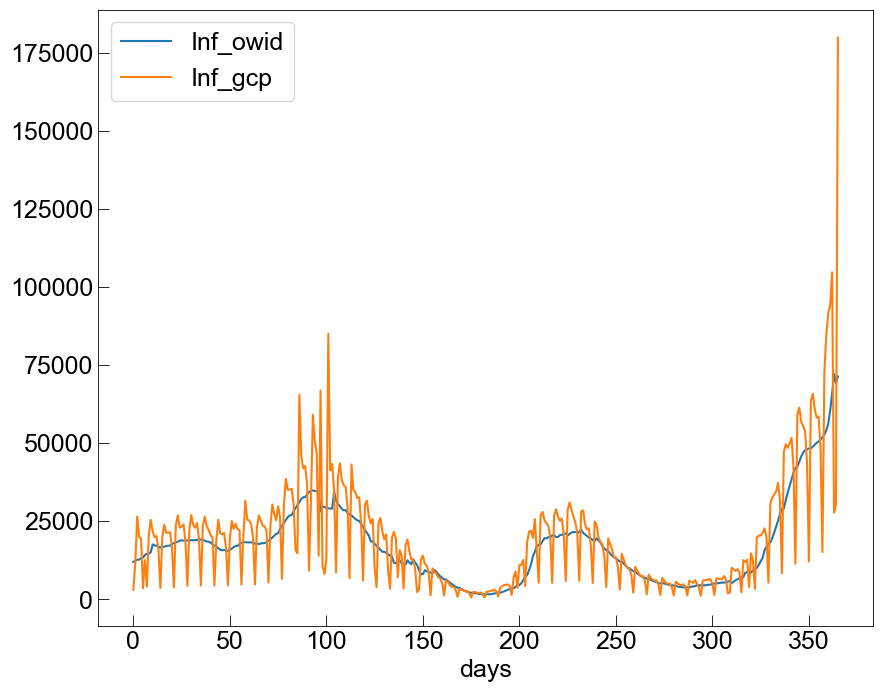

<Figure size 640x480 with 0 Axes>

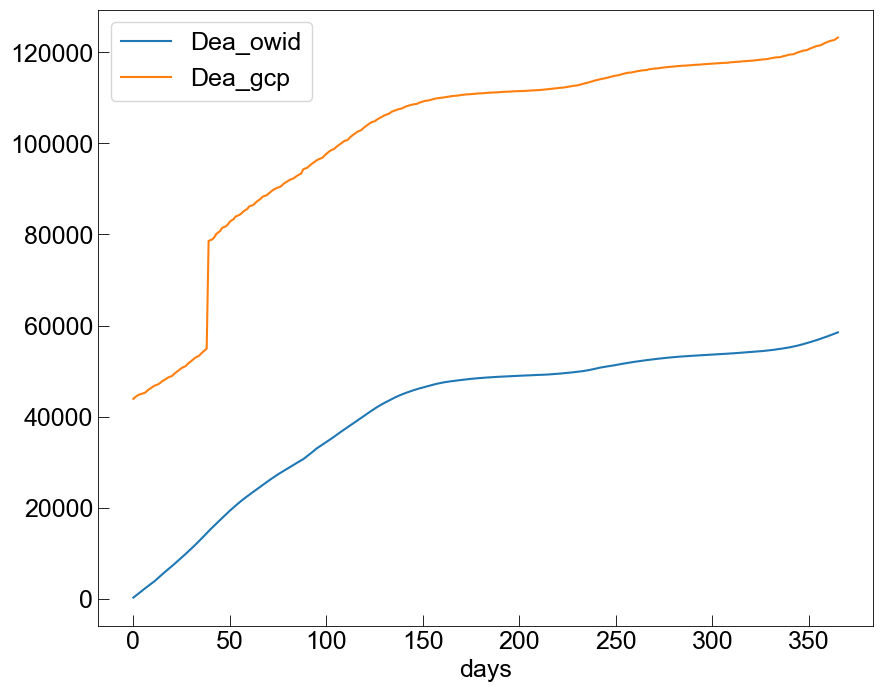

<Figure size 640x480 with 0 Axes>

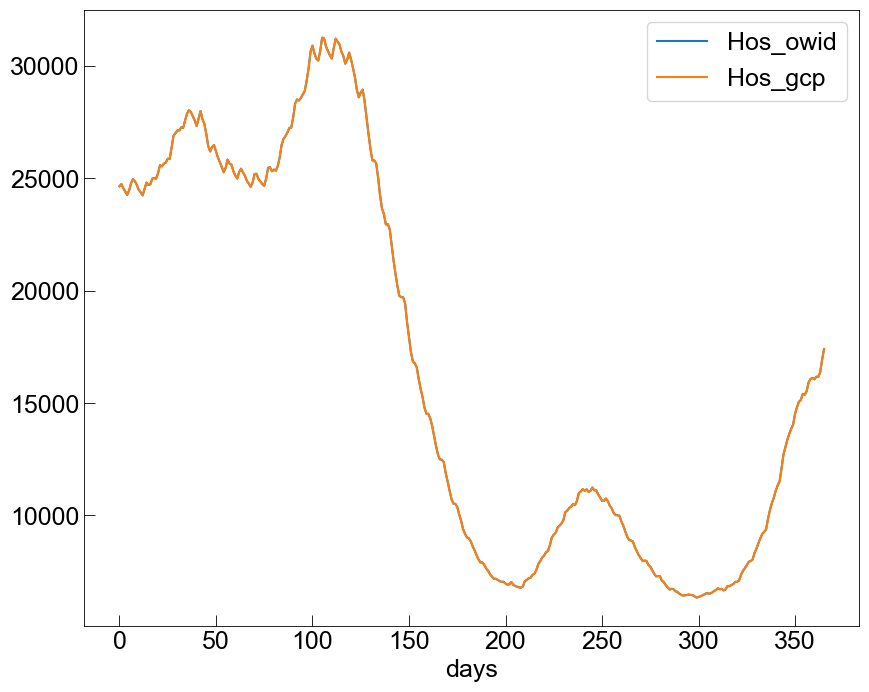

<Figure size 640x480 with 0 Axes>

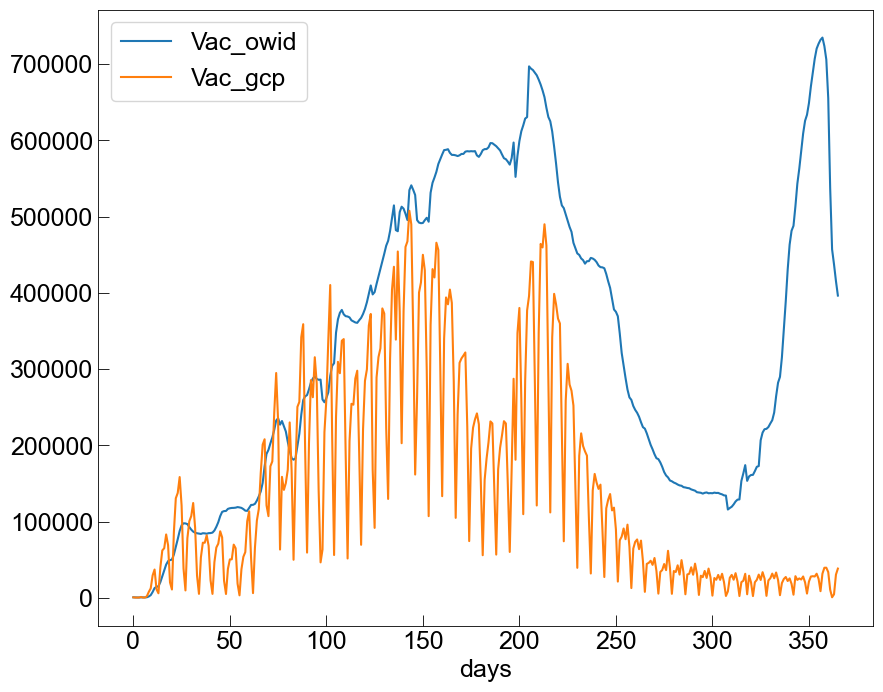

<Figure size 640x480 with 0 Axes>

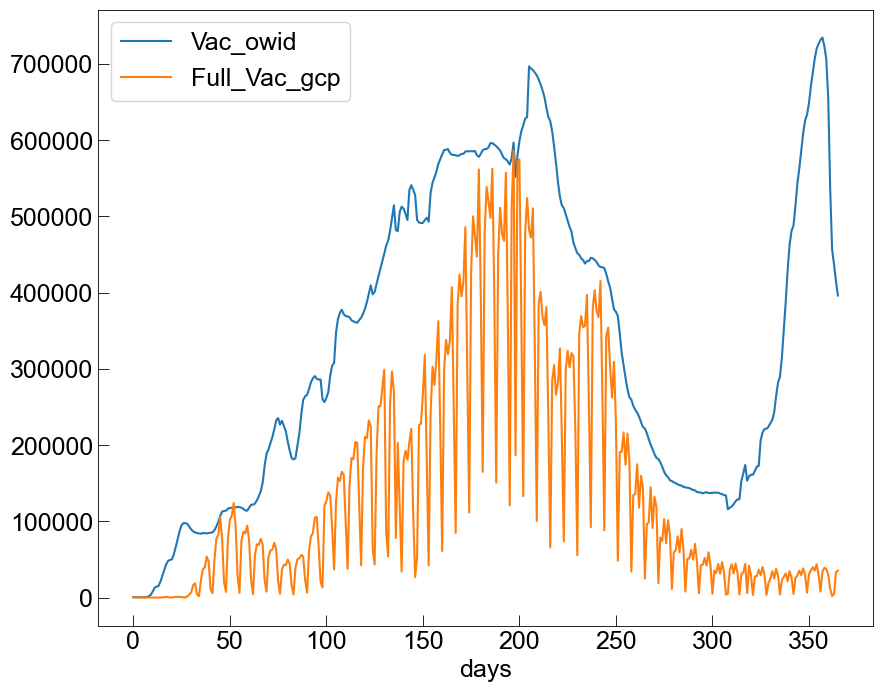

######################## Italy


<Figure size 640x480 with 0 Axes>

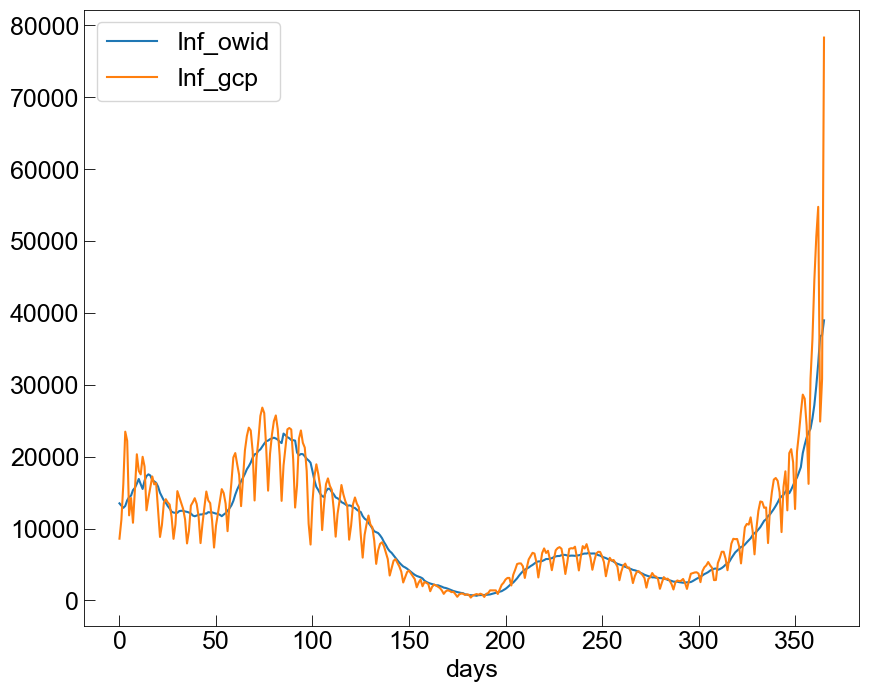

<Figure size 640x480 with 0 Axes>

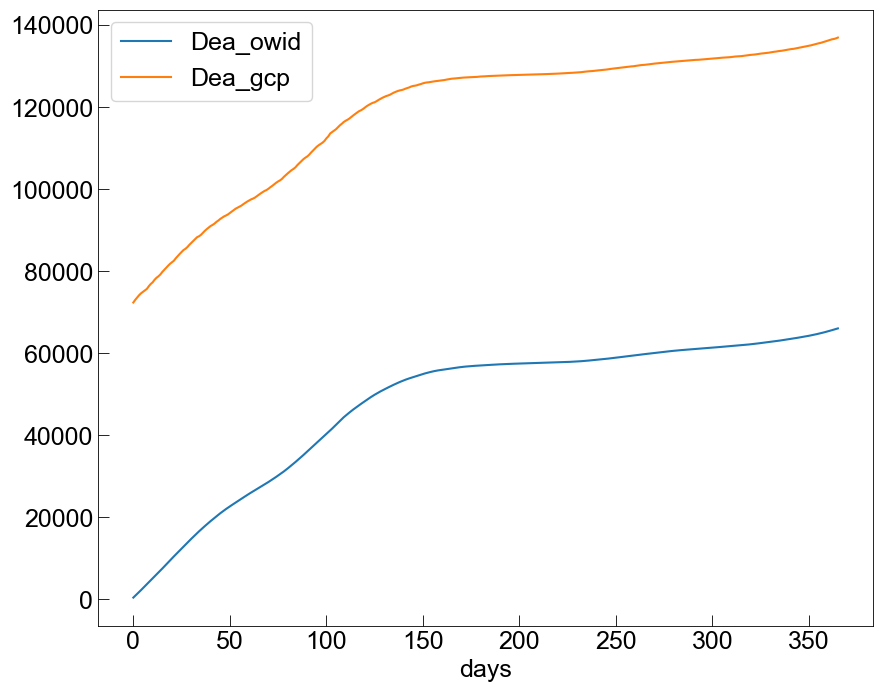

<Figure size 640x480 with 0 Axes>

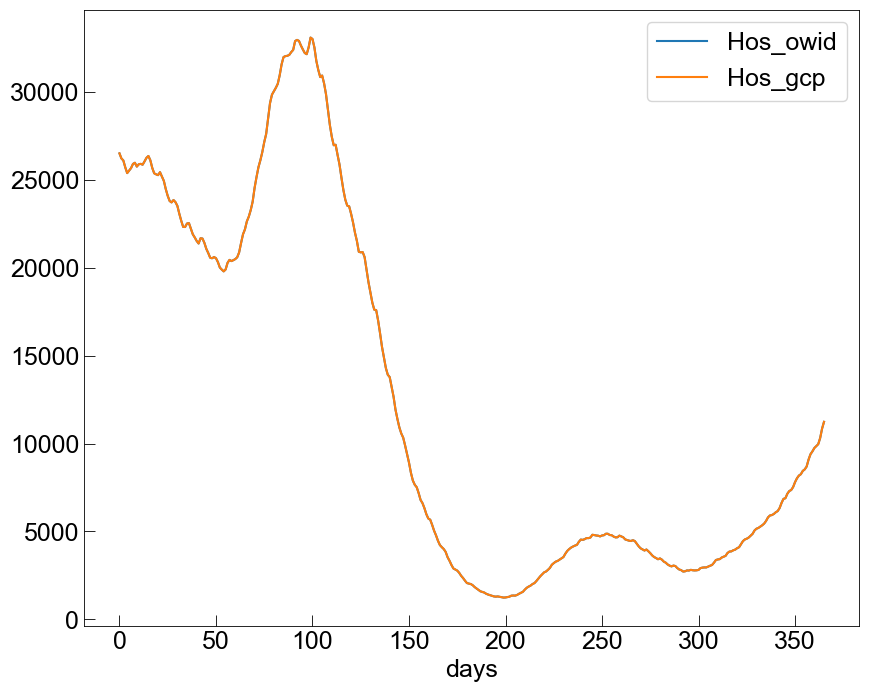

<Figure size 640x480 with 0 Axes>

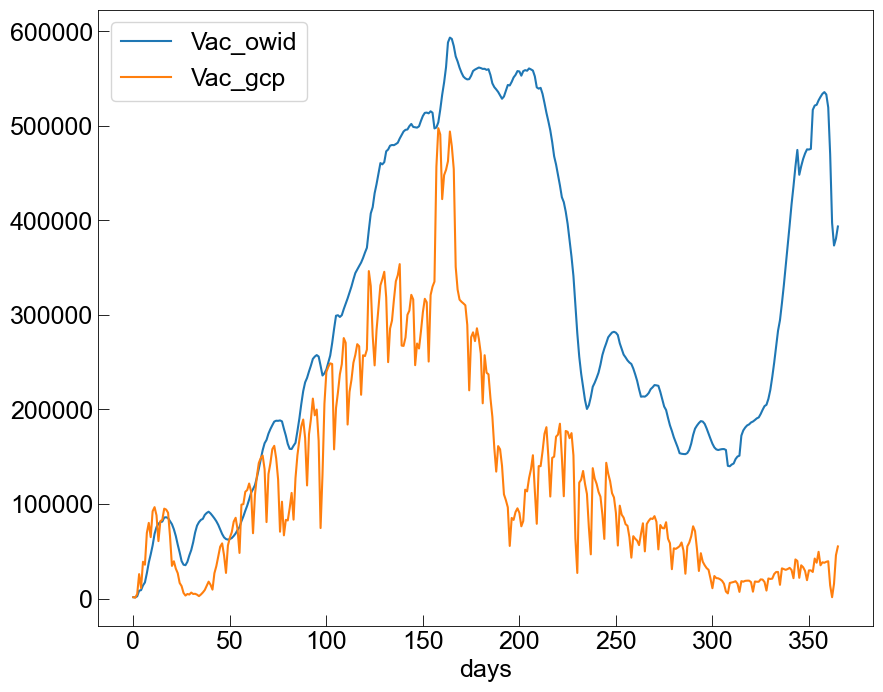

<Figure size 640x480 with 0 Axes>

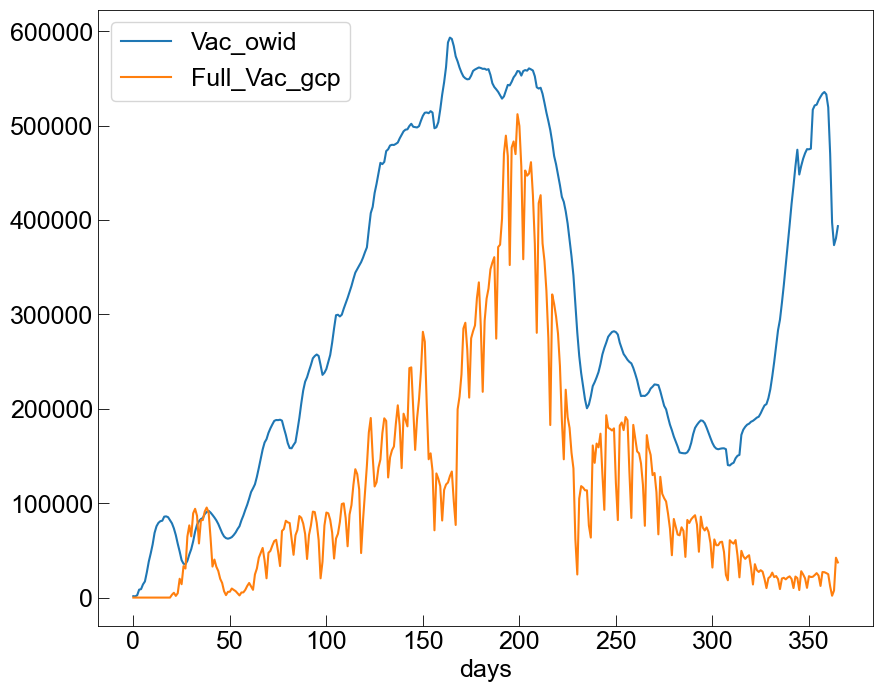

######################## Malaysia


<Figure size 640x480 with 0 Axes>

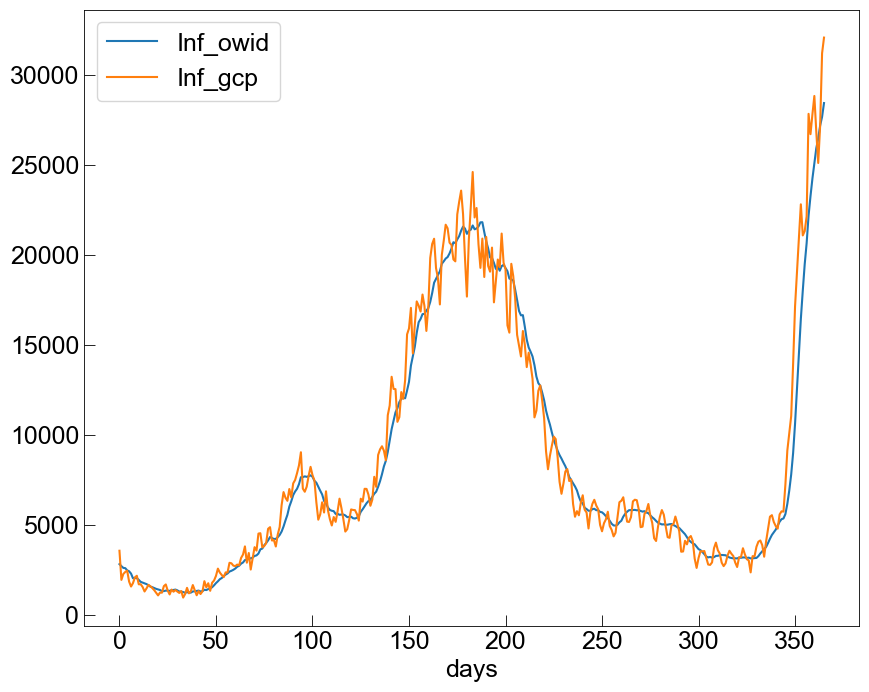

<Figure size 640x480 with 0 Axes>

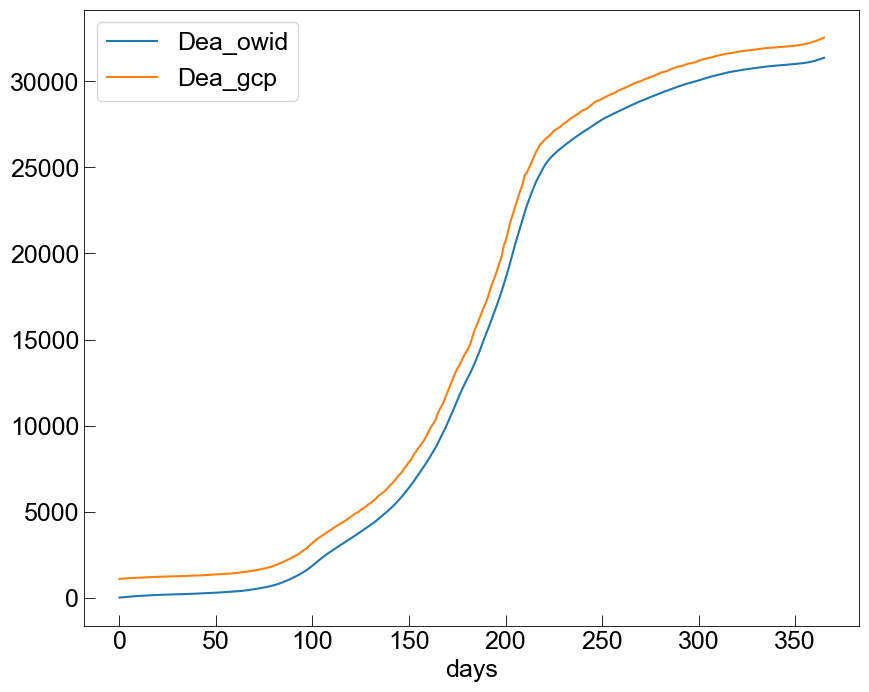

<Figure size 640x480 with 0 Axes>

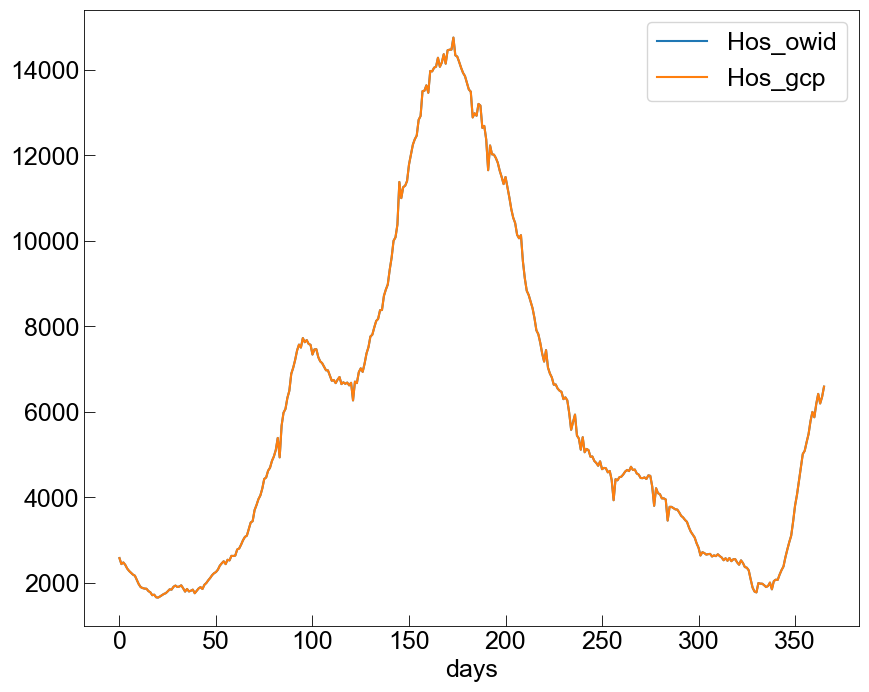

<Figure size 640x480 with 0 Axes>

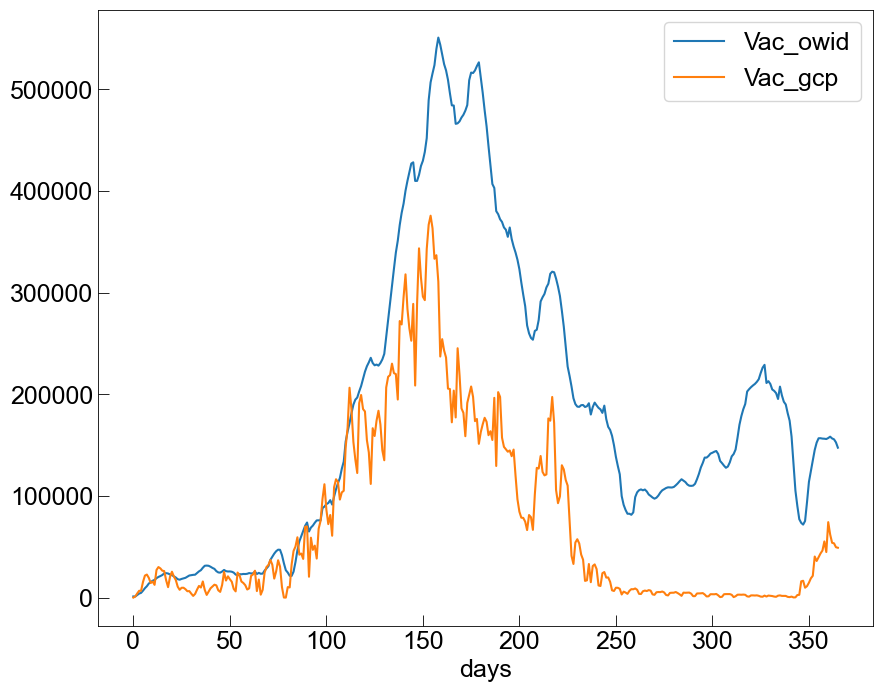

<Figure size 640x480 with 0 Axes>

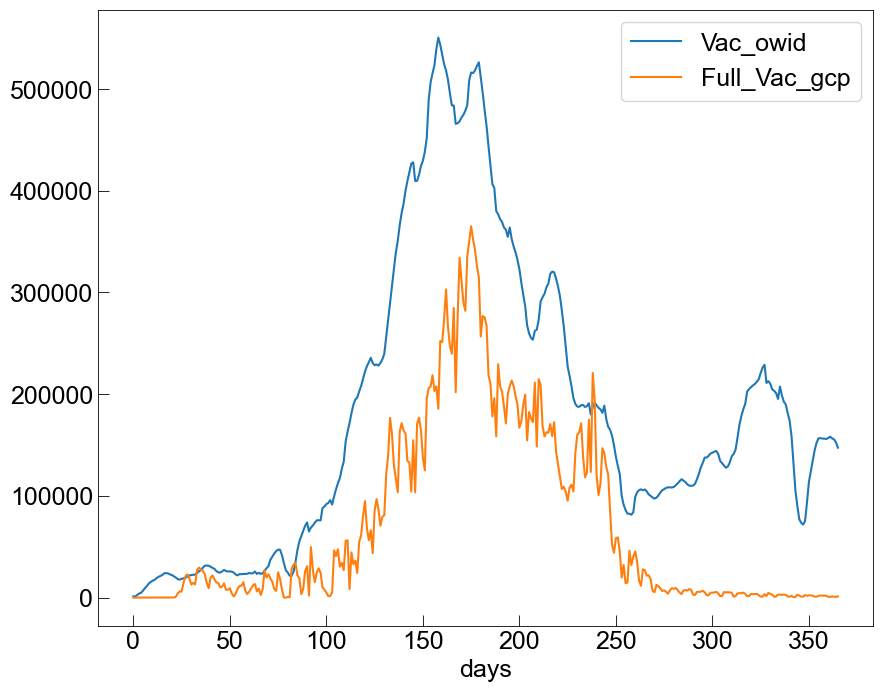

<Figure size 640x480 with 0 Axes>

In [95]:
countries_to_check = np.unique(df_all.location) 

def inc_date(date):
    y, m, d = date.split('-')
    ny = int(y) + 1
    return str(ny) + '-' + m + '-' + d

for country in countries_to_check:
    print(f"######################## {country}")
    country_data_owid = world_data[world_data["location"]==country]
    country_data_gcp = df_all[df_all["location"]==country]
    start_date = max(min(country_data_owid['date']), min(country_data_gcp['date']))
    end_date = inc_date(start_date)
    country_data_owid = country_data_owid.loc[(country_data_owid['date'] >= start_date) & (country_data_owid['date'] <= end_date)]
    country_data_gcp = country_data_gcp.loc[(country_data_gcp['date'] >= start_date) & (country_data_gcp['date'] <= end_date)]
    
    # the infected I compartment
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(np.arange(country_data_owid.shape[0]), country_data_owid["new_cases_smoothed"].values)
    plt.plot(np.arange(country_data_gcp.shape[0]), country_data_gcp["new_confirmed"].values)
    plt.legend(['Inf_owid', 'Inf_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    # the dead D compartment
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(np.arange(country_data_owid.shape[0]), country_data_owid["new_deaths_smoothed"].cumsum().values)
    plt.plot(np.arange(country_data_gcp.shape[0]), country_data_gcp["cumulative_deceased"].values)
    plt.legend(['Dea_owid', 'Dea_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    # the hospitalized H compartment
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(np.arange(country_data_owid.shape[0]), country_data_owid["hosp_patients"].values)
    plt.plot(np.arange(country_data_gcp.shape[0]), country_data_gcp["current_hospitalized_patients"].values)
    plt.legend(['Hos_owid', 'Hos_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    # the vaccinated V compartment
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(np.arange(country_data_owid.shape[0]), country_data_owid["new_vaccinations_smoothed"].values)
    plt.plot(np.arange(country_data_gcp.shape[0]), country_data_gcp["new_persons_vaccinated"].values)
    plt.legend(['Vac_owid', 'Vac_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    # the vaccinated V compartment
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(np.arange(country_data_owid.shape[0]), country_data_owid["new_vaccinations_smoothed"].values)
    plt.plot(np.arange(country_data_gcp.shape[0]), country_data_gcp["new_persons_fully_vaccinated"].values)
    plt.legend(['Vac_owid', 'Full_Vac_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    #plt.grid(False)
    #plt.legend(['infected', 'dead', 'hospitalized', 'vaccinated'])

    
    """ Code to save plots """ 
    #plt.savefig(f"{country}_data.pdf", pad_inches=0, bbox_inches='tight', transparent=True) 

######################## United Kingdom: start_date=2021-01-11, end_date=2022-01-11


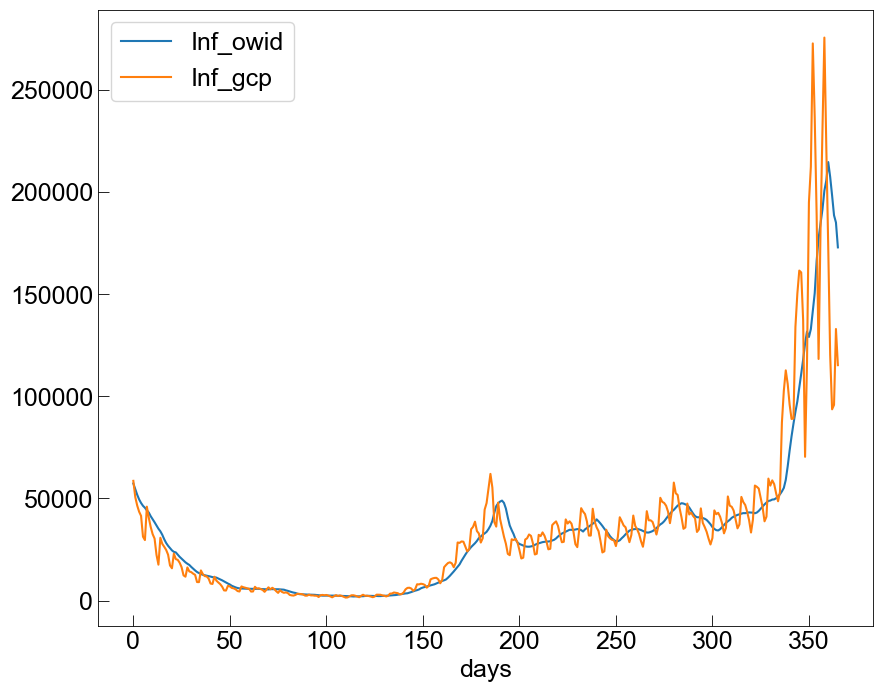

<Figure size 640x480 with 0 Axes>

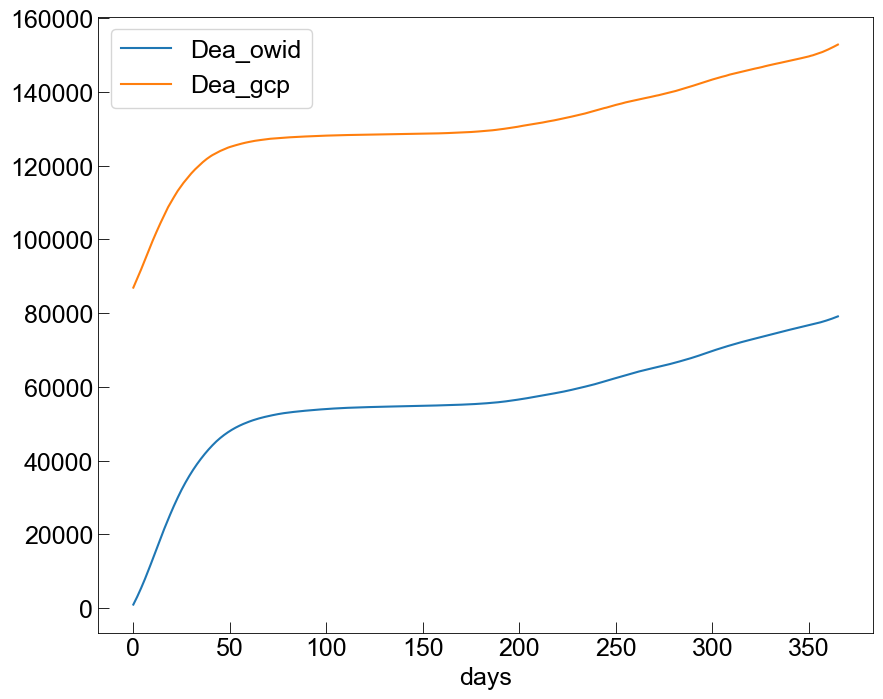

<Figure size 640x480 with 0 Axes>

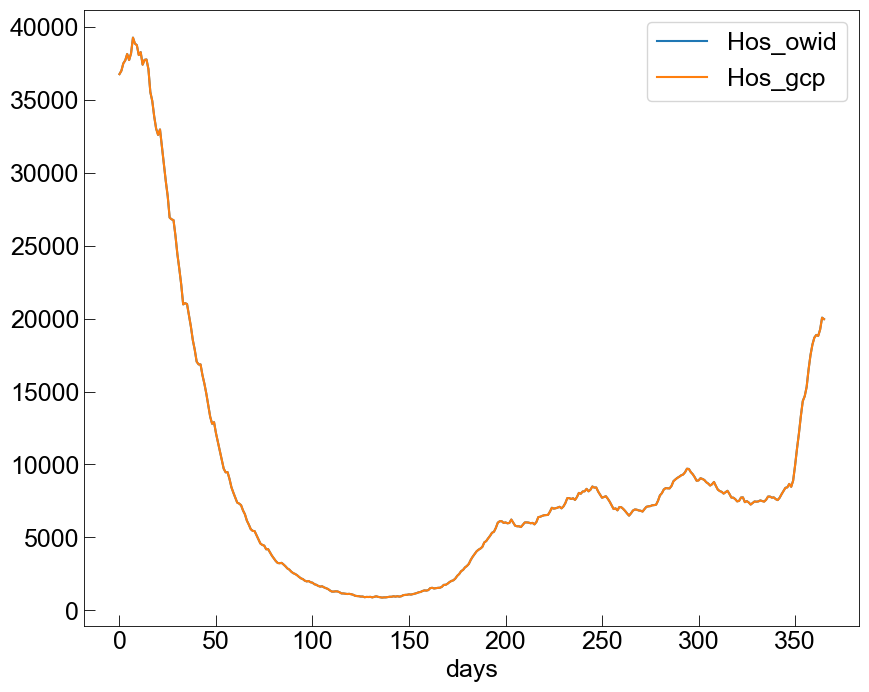

<Figure size 640x480 with 0 Axes>

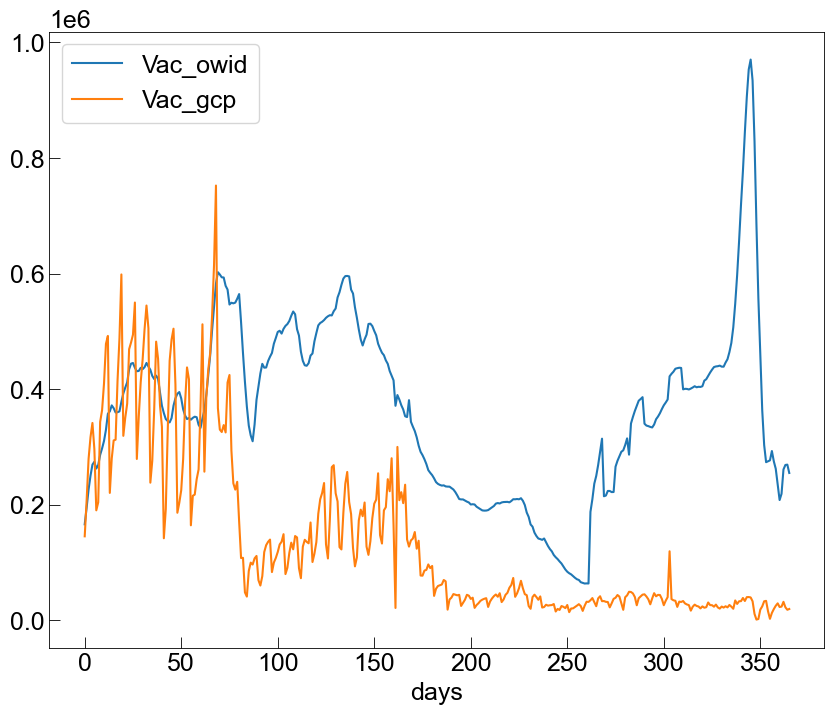

<Figure size 640x480 with 0 Axes>

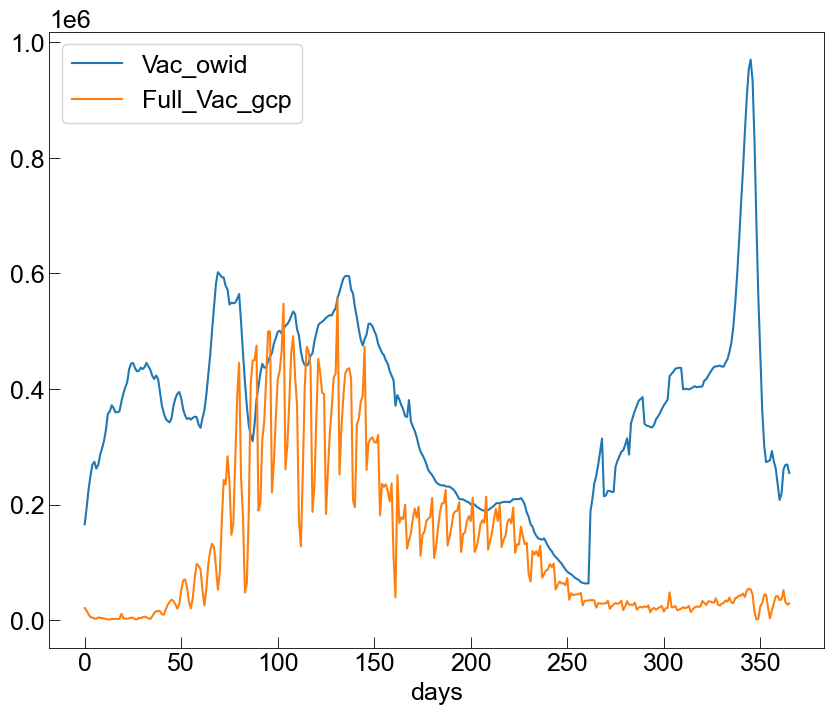

######################## United States: start_date=2020-12-14, end_date=2021-12-14


<Figure size 640x480 with 0 Axes>

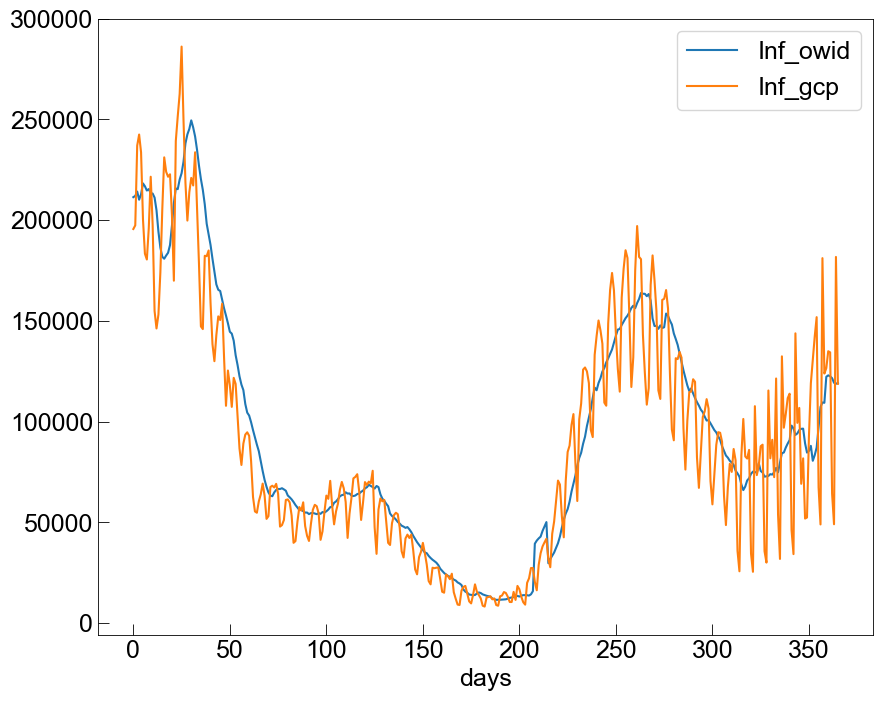

<Figure size 640x480 with 0 Axes>

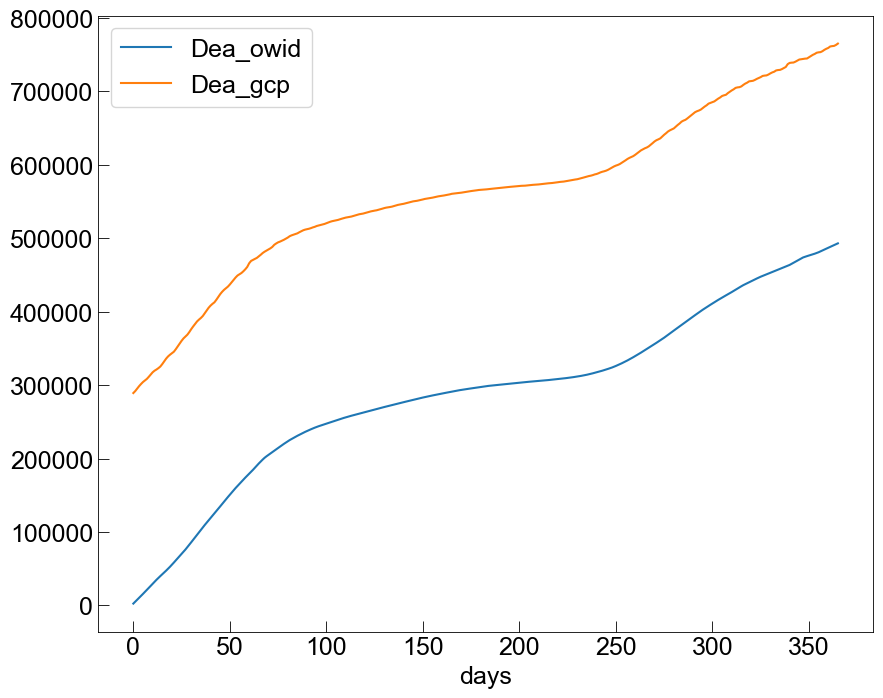

<Figure size 640x480 with 0 Axes>

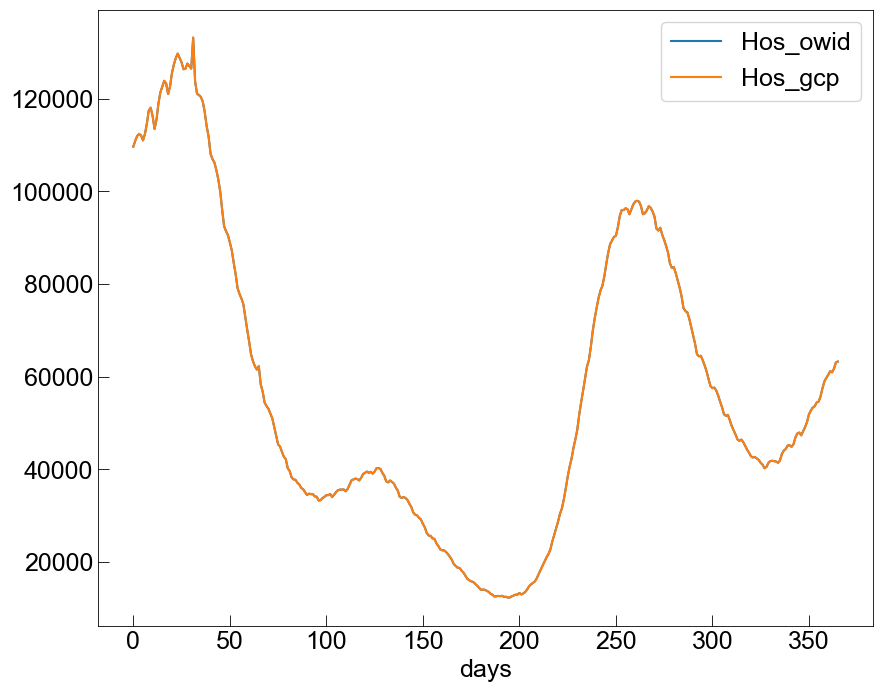

<Figure size 640x480 with 0 Axes>

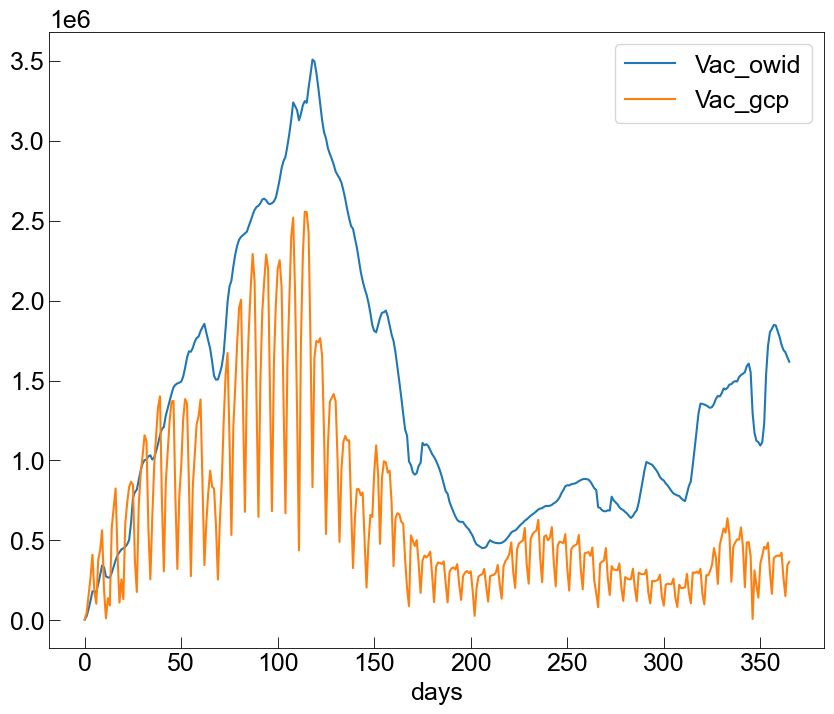

<Figure size 640x480 with 0 Axes>

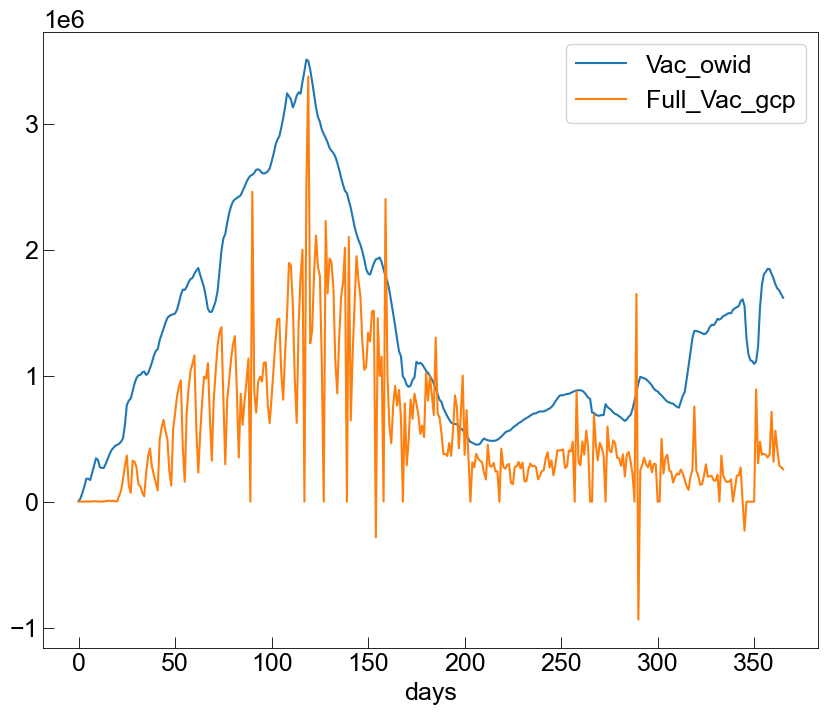

<Figure size 640x480 with 0 Axes>

In [94]:
countries_to_check = np.unique(df_missing.location) 

def inc_date(date):
    y, m, d = date.split('-')
    ny = int(y) + 1
    return str(ny) + '-' + m + '-' + d

for country in countries_to_check:
    country_data_owid = world_data[world_data["location"]==country]
    country_data_gcp = df_missing[df_missing["location"]==country]
    start_date = max(min(country_data_owid['date']), min(country_data_gcp['date']))
    end_date = inc_date(start_date)
    print(f"######################## {country}: start_date={start_date}, end_date={end_date}")
    
    country_data_owid = country_data_owid.loc[(country_data_owid['date'] >= start_date) & (country_data_owid['date'] <= end_date)]
    country_data_gcp = country_data_gcp.loc[(country_data_gcp['date'] >= start_date) & (country_data_gcp['date'] <= end_date)]
    
    # the infected I compartment
    days = np.arange(max(country_data_owid.shape[0],country_data_gcp.shape[0]))
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(days, country_data_owid["new_cases_smoothed"].values)
    plt.plot(days, country_data_gcp["new_confirmed"].values)
    plt.legend(['Inf_owid', 'Inf_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    # the dead D compartment
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(days, country_data_owid["new_deaths_smoothed"].cumsum().values)
    plt.plot(days, country_data_gcp["cumulative_deceased"].values)
    plt.legend(['Dea_owid', 'Dea_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    # the hospitalized H compartment
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(days, country_data_owid["hosp_patients"].values)
    plt.plot(days, country_data_gcp["current_hospitalized_patients"].values)
    plt.legend(['Hos_owid', 'Hos_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    # the vaccinated V compartment
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(days, country_data_owid["new_vaccinations_smoothed"].values)
    plt.plot(days, country_data_gcp["new_persons_vaccinated"].values)
    plt.legend(['Vac_owid', 'Vac_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    # the vaccinated V compartment
    plt.figure(figsize=(10, 8), facecolor="#ffffff")
    plt.plot(days, country_data_owid["new_vaccinations_smoothed"].values)
    plt.plot(days, country_data_gcp["new_persons_fully_vaccinated"].values)
    plt.legend(['Vac_owid', 'Full_Vac_gcp'])
    plt.xlabel('days')
    plt.show()
    plt.clf()
    
    #plt.grid(False)
    #plt.legend(['infected', 'dead', 'hospitalized', 'vaccinated'])

    
    """ Code to save plots """ 
    #plt.savefig(f"{country}_data.pdf", pad_inches=0, bbox_inches='tight', transparent=True) 

In [93]:
start_date, end_date = '2020-04-01', '2021-04-01'
print(min(df_missing[df_missing["location"]=="United Kingdom"]['date']))
print(max(df_missing[df_missing["location"]=="United Kingdom"]['date']))
country_data_gcp = df_missing[df_missing["location"]=="United Kingdom"].loc[(df_missing['date'] >= start_date) & (df_missing['date'] <= end_date)]

country_data_gcp['new_persons_vaccinated'].isna().sum()

2021-01-11
2022-09-07


0

In [87]:
len(df_missing[df_missing["location"]=="United Kingdom"]["new_confirmed"].values)

605